In [1]:
# Data management and investigation
import pandas as pd
import numpy as np
import missingno as msno
from plotnine import *
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

from functools import reduce

In [739]:
# import 2019 reliability, net metering, energy efficiency, advanced metering infrastructure, demand response, and service territory data
reliability_19 = pd.read_excel("Data/Reliability_2019.xlsx", 
                               header = 1)
net_metering_19 = pd.read_excel("Data/Net_Metering_2019.xlsx", 
                                header = [0,1,2])
efficiency_19 = pd.read_excel("Data/Energy_Efficiency_2019.xlsx", 
                              header = [0,1,2])
demand_response_19 = pd.read_excel("Data/Demand_Response_2019.xlsx", 
                              header = [0,1,2])
territory_19 = pd.read_excel("Data/Service_Territory_2019.xlsx")
utility_19 = pd.read_excel("Data/Sales_Ult_Cust_2019.xlsx", 
                                header = [0,1,2])
circuits_19 = pd.read_excel("Data/Distribution_Systems_2019.xlsx")
op_19 = pd.read_excel("Data/Operational_Data_2019.xlsx", 
                                header = [0,1,2])

In [740]:
# Combine the headers together to describe each column
net_metering_19.columns = net_metering_19.columns.map(' - '.join)
efficiency_19.columns = efficiency_19.columns.map(' - '.join)
demand_response_19.columns = demand_response_19.columns.map(' - '.join)
utility_19.columns = utility_19.columns.map(' - '.join)
op_19.columns = op_19.columns.map(' - '.join)

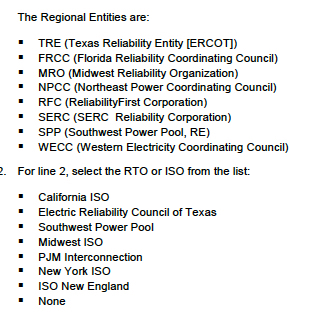

In [741]:
# only grab the columns I want from each dataframe
reliability_19 = reliability_19[['Utility Number',
              'Utility Name', 
              'State', # control
              'Ownership', # control 
              'SAIDI Without MED',
              'SAIFI Without MED', 
              'CAIDI Without MED']].dropna()

In [742]:
reliability_19.columns = ['no', 'name', 'state','type','saidi_nomed', 'saifi_nomed', 'caidi_nomed']

In [743]:
op_19 = op_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
              'Utility Characteristics - Unnamed: 6_level_1 - NERC Region', 
              'Utility Characteristics - Unnamed: 4_level_1 - State',
              'Energy Sources (Megawatthours) - Unnamed: 9_level_1 - Net Generation',
              'Energy Sources (Megawatthours) - Unnamed: 10_level_1 - Wholesale Power Purchases' 
              ]].dropna()

In [744]:
op_19.columns = ['name','nerc','state','gen_mwh','purchase_mwh']

In [745]:
net_metering_19 = net_metering_19[['Utility Characteristics - Unnamed: 3_level_1 - Utility Name',
                                   'Utility Characteristics - Unnamed: 1_level_1 - State',
                                   'Utility Characteristics - Unnamed: 5_level_1 - BA Code',
                'Photovoltaic - Energy Sold Back MWh - Total',
                'Wind - Energy Sold Back MWh - Total',
                'All Technologies - Energy Sold Back MWh - Total',
                ]].dropna()

In [746]:
net_metering_19.columns = ['name', 'state', 'ba','pv_mwh', 'wind_mwh', 'nm_mwh']

In [747]:
efficiency_19 = efficiency_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
                               'Utility Characteristics - Unnamed: 4_level_1 - State',
                  'Reporting Year Incremental Annual Savings - Energy Savings (MWh) - Total']].dropna()

In [748]:
efficiency_19.columns = ['name','state','ee_mwh']

In [749]:
demand_response_19 = demand_response_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
                                         'Utility Characteristics - Unnamed: 4_level_1 - State',
                    'Yearly Energy and Demand Savings - Number of Customers Enrolled - Total',
                    'Yearly Energy and Demand Savings - Energy Savings (MWh) - Total']].dropna()

In [750]:
demand_response_19.columns = ['name', 'state','dem_res_customers', 'dem_res_mwh']

In [751]:
territory_19 = territory_19[['Utility Name',
             'State',
             'County']]

In [752]:
territory_19.columns = ['name', 'state', 'county']

In [753]:
utility_19 = utility_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
                         'Utility Characteristics - Unnamed: 6_level_1 - State',
                         'TOTAL - Sales - Megawatthours',
                         'TOTAL - Customers - Count']]

In [754]:
utility_19.columns = ['name', 'state','total_mwh','total_cust']

In [755]:
circuits_19 = circuits_19[['Utility Name',
                           'State',
                           'Distribution Circuits',
                         'Circuits with Voltage Optimization']]

In [756]:
circuits_19.columns = ['name', 'state','circuits', 'voltage']

In [757]:
# merge all the lists together by utility name 
df_list = [utility_19, reliability_19, circuits_19, op_19, net_metering_19, efficiency_19, demand_response_19]
df_19 = reduce(lambda left,right: pd.merge(left,right,on=['name','state'], how='outer'), df_list)

In [758]:
# drop the duplicate rows 
df_19 = df_19[~df_19.duplicated(['name', 'state'])]

In [759]:
# drop all the entries where my outcome variable is not present (SAIDI, SAIFI and CAIDI are same – I checked)
df_19 = df_19[~df_19.saidi_nomed.isna()]

In [760]:
# remove those missing total customer data and total megawatthours (5 rows)
df_19 = df_19[~df_19.total_mwh.isna()]
df_19 = df_19[~df_19.total_cust.isna()]

In [761]:
df_19.isna().sum(axis=0)

name                   0
state                  0
total_mwh              0
total_cust             0
no                     0
type                   0
saidi_nomed            0
saifi_nomed            0
caidi_nomed            0
circuits               0
voltage                0
nerc                 112
gen_mwh              112
purchase_mwh         112
ba                   316
pv_mwh               316
wind_mwh             316
nm_mwh               316
ee_mwh               740
dem_res_customers    858
dem_res_mwh          858
dtype: int64

In [699]:
# fill na's with 0 
# i assume that if they didn't fill it out, there is nothing to report
df_19 = df_19.fillna(0).reset_index(drop=True)

In [762]:
df_19.shape

(1179, 21)

### Try alternative method where I don't fillna

In [690]:
df_19_nona = df_19.copy()

In [718]:
df_19_nona.isna().sum(axis=0)

name                 0
state                0
total_mwh            0
total_cust           0
no                   0
type                 0
saidi_nomed          0
saifi_nomed          0
caidi_nomed          0
circuits             0
voltage              0
nerc                 0
gen_mwh              0
purchase_mwh         0
ba                   0
pv_mwh               0
wind_mwh             0
nm_mwh               0
ee_mwh               0
dem_res_customers    0
dem_res_mwh          0
dtype: int64

In [715]:
df_19_nona = df_19_nona.dropna(axis=0, subset = ['gen_mwh','dem_res_customers','ee_mwh','pv_mwh'])

In [717]:
df_19_nona

,name,state,total_mwh,total_cust,no,type,saidi_nomed,saifi_nomed,caidi_nomed,circuits,...,nerc,gen_mwh,purchase_mwh,ba,pv_mwh,wind_mwh,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh
45,City of Alexandria - (MN),MN,281812.0,10144.0,295.0,Municipal,.,.,.,25.0,...,MRO,66.0,291147.0,MISO,16.019,0.000,31.219,4414.600,2821.0,0.000
53,"Allamakee-Clayton El Coop, Inc",IA,133395.0,9987.0,329.0,Cooperative,141.6,0.965,146.736,53.0,...,MRO,148.0,150540.0,MISO,1035.749,0.144,1035.893,1124.000,2768.0,0.000
68,City of Ames - (IA),IA,639455.0,26956.0,554.0,Municipal,15.79,0.19,83.1053,41.0,...,MRO,126113.0,663514.0,MISO,0.000,0.000,0.000,4218.000,10683.0,0.000
74,City of Anaheim - (CA),CA,2237118.0,120279.0,590.0,Municipal,42.12,0.57,73.8947,123.0,...,WECC,22353.0,3009839.0,CISO,0.000,0.000,0.000,26739.841,14.0,0.000
101,Arizona Public Service Co,AZ,27844577.0,1260386.0,803.0,Investor Owned,86.8,0.843,102.966,1386.0,...,WECC,26805008.0,7156889.0,AZPS,0.000,0.000,0.000,143225.000,693725.0,977215.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,Cass County Elec Coop Inc,ND,1287375.0,52086.0,24949.0,Cooperative,30.56,0.498,61.3655,41.0,...,MRO,0.0,1328581.0,MISO,125.245,56.811,182.056,10.000,9743.0,6223.560
3170,"Red Lake Electric Coop, Inc",MN,117401.0,5636.0,26934.0,Cooperative,.,.,.,34.0,...,MRO,0.0,135768.0,MISO,26.492,1.094,27.586,479.833,2176.0,549.201
3171,Red River Valley Coop Pwr Assn,MN,124264.0,4681.0,26939.0,Cooperative,81,0.62,130.645,43.0,...,MRO,0.0,131002.0,MISO,0.000,0.000,0.000,1463.000,2007.0,0.000
3360,City of Moreno Valley - (CA),CA,193012.0,6857.0,55787.0,Municipal,.,.,.,20.0,...,WECC,898.0,204468.0,CISO,0.000,0.000,0.000,8050.000,15.0,41.445


In [767]:
df_19_nona.dtypes

name                  object
state                 object
total_mwh            float64
total_cust           float64
no                   float64
type                  object
saidi_nomed           object
saifi_nomed           object
caidi_nomed           object
circuits             float64
voltage              float64
nerc                  object
gen_mwh              float64
purchase_mwh         float64
ba                    object
pv_mwh               float64
wind_mwh             float64
nm_mwh               float64
ee_mwh               float64
dem_res_customers    float64
dem_res_mwh          float64
pv_pct               float64
nm_pct               float64
ee_pct               float64
dem_res_pct          float64
dem_res_cust_pct     float64
dtype: object

In [763]:
df_19_nona['pv_pct'] = ((df_19_nona['pv_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [764]:
df_19['wind_pct'] = ((df_19_nona['wind_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [765]:
df_19_nona['nm_pct'] = ((df_19_nona['nm_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [766]:
df_19_nona['ee_pct'] = ((df_19_nona['ee_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [735]:
df_19_nona['dem_res_pct'] = ((df_19_nona['dem_res_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [736]:
df_19_nona['dem_res_cust_pct'] = ((df_19_nona['dem_res_customers']/df_19_nona['total_cust']) * 100).fillna(0)

In [737]:
df_19_nona = df_19_nona[(df_19_nona.saidi_nomed != '.')].reset_index(drop=True)

In [738]:
# export as CSV so I can use it in my next step
df_19_nona.to_csv("df_19_nona.csv",index=False)

### Final check for accuracy

In [120]:
df_19.sample(6)

,name,state,total_mwh,total_cust,no,type,saidi_nomed,saifi_nomed,caidi_nomed,circuits,...,nerc,gen_mwh,purchase_mwh,ba,pv_mwh,wind_mwh,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh
411,"HILCO Electric Cooperative, Inc.",TX,591343.0,29380.0,8620.0,Cooperative,72.202,0.911,79.2558,44.0,...,TRE,0.0,626620.0,ERCO,0.0,0.0,0.0,152.510,0.0,0.0
1102,Wisconsin Power & Light Co,WI,11017009.0,475545.0,20856.0,Investor Owned,.,.,.,1160.0,...,MRO,9927167.0,4090139.0,MISO,0.0,0.0,0.0,0.000,126.0,186.0
757,Pacific Gas & Electric Co.,CA,36462157.0,2635291.0,14328.0,Investor Owned,134.1,0.995,134.774,3109.0,...,WECC,33491087.0,42164686.0,CISO,0.0,0.0,0.0,1322045.000,268381.0,3963.0
82,"Bowie-Cass Electric Coop, Inc",TX,642083.0,37907.0,2049.0,Cooperative,.,.,.,110.0,...,SPP,0.0,691495.0,SWPP,0.0,0.0,0.0,0.000,0.0,0.0
1072,Village of Waunakee - (WI),WI,118605.0,6531.0,20211.0,Municipal,80.63,0.54,149.315,16.0,...,MISO,0.0,122440.0,MISO,0.0,0.0,0.0,0.000,0.0,0.0
1089,City of Westfield - (MA),MA,353536.0,18061.0,20481.0,Municipal,80.332,1.713,46.8955,14.0,...,NPCC,0.0,359788.0,0,0.0,0.0,0.0,3297.428,0.0,0.0


Here, I did a check on a random sample of 6 observations across categories to make sure everything looked good. When there's a NA for any of the reliability metrics, that means that data was missing from the survey, and I cannot simply impute with 0's – that would incorrectly be assuming that they had no system interruptions. My best option is to simply drop these rows, since they lack my outcome variable.

### Make the percentage net metering, energy efficiency, and demand response columns. 

In [121]:
df_19['pv_pct'] = ((df_19['pv_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [122]:
df_19['wind_pct'] = ((df_19['wind_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [123]:
df_19['nm_pct'] = ((df_19['nm_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [124]:
df_19['ee_pct'] = ((df_19['ee_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [125]:
df_19['dem_res_pct'] = ((df_19['dem_res_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [126]:
df_19['dem_res_cust_pct'] = ((df_19['dem_res_customers']/df_19['total_cust']) * 100).fillna(0)

### Need to justify using SAIDI rather than SAIFI or CAIDI

There are 766 entries for SAIDI, and only about 705 for SAIFI and CAIDI. Therefore, I will be using SAIDI as my index for grid reliability.

In [127]:
# check non zero entries
#df_19[(df_19.saifi_nomed != '.')]

In [128]:
# limit dataframe to SAIDI, which has the most nonzero entries 
df_19 = df_19[(df_19.saidi_nomed != '.')].reset_index(drop=True)

In [129]:
df_19.describe()

,total_mwh,total_cust,no,circuits,voltage,gen_mwh,purchase_mwh,pv_mwh,wind_mwh,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh,pv_pct,wind_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
count,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,7.670000e+02,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,2.877815e+06,1.325098e+05,12300.241199,190.542373,47.014342,1.603899e+06,1.562233e+06,1549.682040,85.946874,1643.192293,2.754904e+04,12274.062581,1751.307789,0.063293,0.002523,0.066940,0.368537,0.018130,4.560795
std,8.153767e+06,3.853289e+05,8559.434421,475.750289,205.103511,8.019806e+06,4.091160e+06,18568.046351,1827.784027,20219.445852,1.255740e+05,69746.807005,35827.024220,0.496231,0.029555,0.512219,1.061427,0.179930,13.820391
min,2.829000e+03,4.100000e+01,97.000000,1.000000,0.000000,-5.120000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.374375e+05,1.095350e+04,5896.000000,30.000000,0.000000,0.000000e+00,1.591930e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.314040e+05,2.415200e+04,12268.000000,57.000000,0.000000,0.000000e+00,4.425630e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.484748e+06,6.527150e+04,16715.000000,123.000000,19.000000,4.650000e+01,1.078380e+06,55.925500,0.000000,65.226500,1.209000e+03,31.500000,0.000000,0.007547,0.000000,0.008335,0.237313,0.000000,0.035619
max,1.119557e+08,5.061483e+06,60839.000000,5619.000000,2787.000000,1.265085e+08,5.667982e+07,466156.237000,49255.057000,515411.294000,2.097423e+06,895133.000000,977215.000000,10.630452,0.758238,10.630452,10.727103,3.509534,100.000000


In [130]:
#df_19 = df_19.drop(['pv_mwh',
#            'wind_mwh',
#            'nm_mwh',
#            'ee_mwh',
#            'dem_res_customers',
#            'dem_res_mwh'], axis = 1)

In [131]:
df_19.sort_values(by='name')

,name,state,total_mwh,total_cust,no,type,saidi_nomed,saifi_nomed,caidi_nomed,circuits,...,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh,pv_pct,wind_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
220,4-County Electric Power Assn,MS,1090317.0,48915.0,6641.0,Cooperative,125.82,1.47,85.5918,89.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
400,"ALLETE, Inc.",MN,9014805.0,147340.0,12647.0,Investor Owned,144.02,1.35,106.681,369.0,...,577.929,61243.0,7897.0,746.00,0.006352,0.000059,0.006411,0.679360,0.008275,5.359712
0,Adams Electric Coop,IL,176102.0,8931.0,97.0,Cooperative,169.74,1.29,131.581,47.0,...,0.000,0.0,4402.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,49.288993
1,Adams-Columbia Electric Coop,WI,515186.0,37607.0,108.0,Cooperative,139.9,0.95,147.263,95.0,...,728.010,0.0,4781.0,13647.36,0.136994,0.004316,0.141310,0.000000,2.649016,12.713059
2,Agralite Electric Coop,MN,238558.0,5251.0,155.0,Cooperative,128.759,1.181,109.025,64.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,Wyrulec Company,WY,171783.0,4822.0,21079.0,Cooperative,164.019,1.128,145.407,37.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
720,Wyrulec Company,NE,18771.0,499.0,21079.0,Cooperative,353.521,2.228,158.672,8.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
719,Y-W Electric Assn Inc,CO,335317.0,8783.0,21075.0,Cooperative,62.7,.,.,89.0,...,2.523,112.7,0.0,0.00,0.000752,0.000000,0.000752,0.033610,0.000000,0.000000
722,Yampa Valley Electric Assn Inc,CO,552803.0,27065.0,21081.0,Cooperative,203.5,2.421,84.0562,123.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


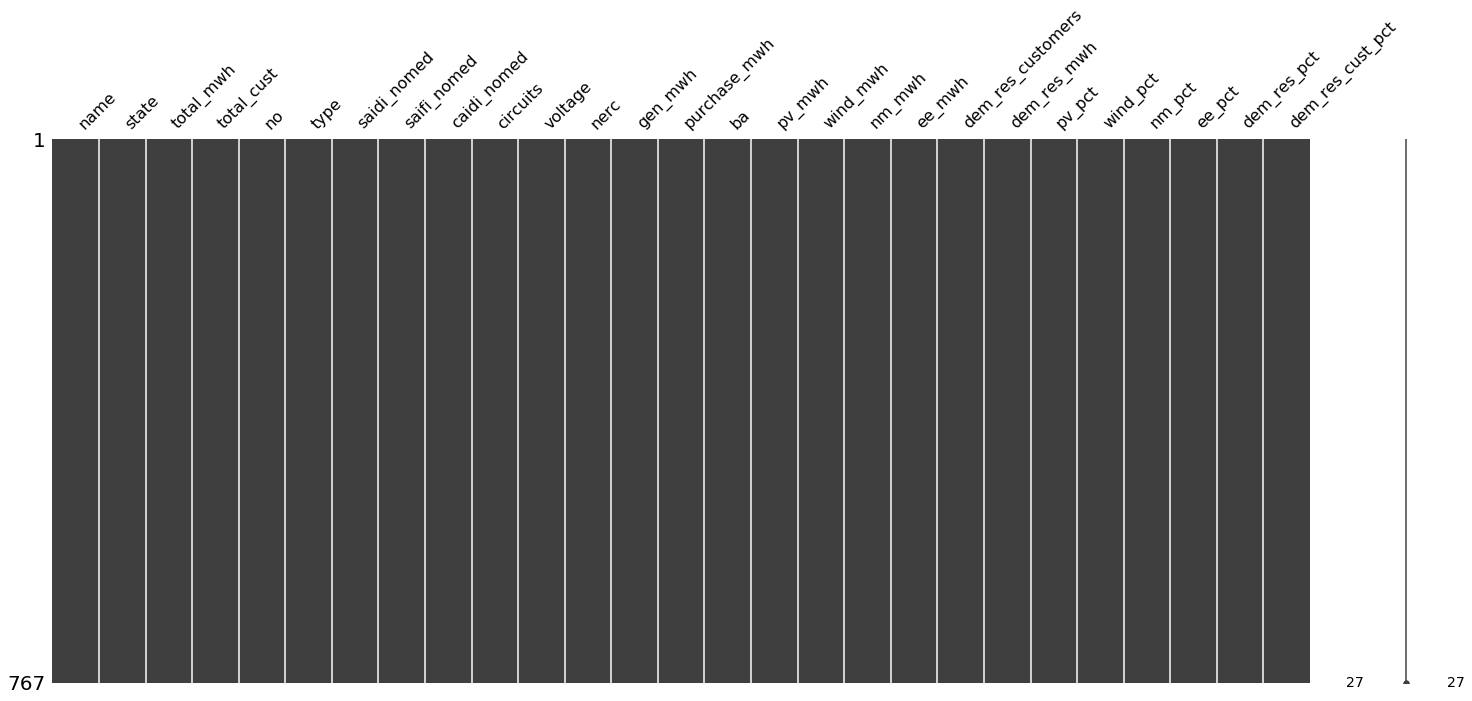

In [132]:
# make sure we're good to go
msno.matrix(df_19)

In [133]:
# export as CSV so I can use it in my next step
df_19.to_csv("df_19.csv",index=False)

## Unresolved pile

In [ ]:
# when we mergeed our dataframes, they dropped all the adjustments
# we decide to ignore these based on expert feedback
net_metering_19[net_metering_19['name'].str.contains("Adjustment")]

# Discard pile

In [ ]:
#rel_ut = reliability_19.merge(utility_19, on = ["name","state"])

In [ ]:
#rel_ut.merge(utility_19, on = ["name","state"])

In [ ]:
# was going to use to merge columns but not necessary
#cols = [col for col in net_metering_19.columns if 'Unnamed:' not in col]